<a href="https://colab.research.google.com/github/davinnnnn/Image-Classification/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# 해당 링크(https://tutorials.pytorch.kr/beginner/colab)를 참조하여 PyTorch와 관련된 추가 정보를 얻을 수 있습니다.
# `%matplotlib inline`은 Jupyter Notebook 또는 Google Colab과 같은 환경에서
# 그래프나 시각화 결과를 바로 노트북 안에 출력하도록 설정하는 매직 커맨드입니다.
%matplotlib inline



# 분류기(Classifier) 학습하기

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

## 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용합니다.

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상으로 이뤄져 있다는 것을 뜻합니다.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## 이미지 분류기 학습하기

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

### 1. CIFAR10을 불러오고 정규화하기

``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.


In [2]:
# torch를 임포트합니다. torch는 PyTorch 라이브러리의 주요 네임스페이스로,
# 텐서 연산, 그래디언트, 신경망 등의 핵심 기능들을 포함하고 있습니다.
import torch

# torchvision은 PyTorch에 포함된 컴퓨터 비전 관련 도구 및 데이터셋을 제공하는 라이브러리입니다.
# 이를 통해 여러 유명한 이미지 데이터셋을 쉽게 불러오거나 전처리할 수 있습니다.
import torchvision

# torchvision.transforms는 이미지 전처리를 위한 다양한 함수와 변환 클래스들을 제공합니다.
# 예를 들면, 이미지를 텐서로 변환하거나, 정규화, 리사이징, 회전 등의 작업을 수행할 수 있습니다.
import torchvision.transforms as transforms


torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [3]:
# transforms.Compose는 여러 변환들을 함께 조합하여 순차적으로 적용하는 기능을 제공합니다.
transform = transforms.Compose(
    [
     # 이미지를 PyTorch 텐서(Tensor)로 변환합니다.
     transforms.ToTensor(),

     # 이미지를 정규화합니다. 주어진 평균과 표준편차를 사용하여 채널별로 정규화합니다.
     # 여기서는 모든 채널에 대해 평균 0.5, 표준편차 0.5로 정규화를 수행합니다.
     # 이렇게 하면 텐서의 값이 -1에서 1 사이의 값으로 변환됩니다.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 배치 크기를 설정합니다. 여기서는 한 번에 4개의 이미지를 로드하도록 설정되었습니다.
batch_size = 4

# CIFAR-10 훈련 데이터셋을 다운로드하고 로드합니다.
trainset = torchvision.datasets.CIFAR10(root='./data',   # 데이터를 저장할 경로
                                        train=True,      # 훈련 데이터셋을 사용
                                        download=True,   # 데이터셋을 다운로드
                                        transform=transform)  # 위에서 정의한 transform을 적용

# DataLoader는 데이터셋을 배치 단위로 로드하는 기능을 제공합니다.
# 여기서는 훈련 데이터를 로드하는 DataLoader를 생성합니다.
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,  # 데이터를 무작위로 섞음
                                          num_workers=2) # 멀티 프로세싱을 위한 워커 수

# CIFAR-10 테스트 데이터셋을 다운로드하고 로드합니다.
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,     # 테스트 데이터셋을 사용
                                       download=True,
                                       transform=transform)

# 테스트 데이터를 로드하는 DataLoader를 생성합니다.
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False, # 테스트 데이터는 섞지 않음
                                         num_workers=2)

# CIFAR-10 데이터셋에 포함된 클래스(레이블)의 이름들을 튜플로 저장합니다.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:06<00:00, 27989199.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


재미삼아 학습용 이미지 몇 개를 보겠습니다.



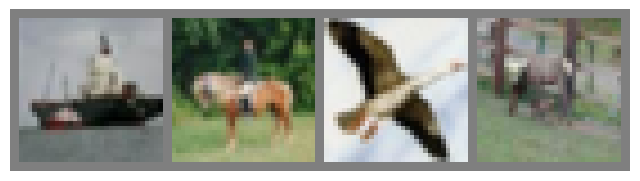

Labels:  ship  horse bird  deer 


In [4]:
import matplotlib.pyplot as plt  # 시각화 라이브러리
import numpy as np  # 수치 연산 라이브러리

# 이미지를 화면에 출력하기 위한 함수를 정의합니다.
def imshow(img):
    img = img / 2 + 0.5     # unnormalize: 위에서 [-1,1] 범위로 정규화된 이미지를 [0,1] 범위로 되돌립니다.
    npimg = img.numpy()     # PyTorch 텐서를 numpy 배열로 변환합니다.

    # 이미지를 화면에 출력합니다.
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) 형태의 배열을 (H, W, C)로 바꾸어 줍니다.
    plt.axis('off')  # 이미지에 축 정보를 나타내지 않습니다.
    plt.show()

# 학습 데이터에서 배치 단위로 데이터를 무작위로 가져옵니다.
dataiter = iter(trainloader)
images, labels = next(dataiter)  # 첫 번째 배치의 이미지와 레이블을 가져옵니다.

# 이미지를 그리드 형태로 변환하고 화면에 출력합니다.
imshow(torchvision.utils.make_grid(images))

# 이미지에 해당하는 레이블(클래스명)을 출력합니다.
print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### 2. 합성곱 신경망(Convolution Neural Network) 정의하기
이전의 신경망 섹션에서 신경망을 복사한 후, (기존에 1채널 이미지만 처리하도록
정의된 것을) 3채널 이미지를 처리할 수 있도록 수정합니다.



In [5]:
# 필요한 라이브러리와 모듈을 임포트합니다.
import torch.nn as nn
import torch.nn.functional as F

# 'Net'이라는 이름의 컨볼루션 신경망 클래스를 정의합니다.
class Net(nn.Module):
    def __init__(self):
        # nn.Module의 초기화 함수를 호출하여 모델의 기본 구성을 준비합니다.
        super().__init__()

        # 첫 번째 컨볼루션 레이어입니다.
        # 입력 채널 수는 3 (RGB 이미지), 출력 채널 수는 6이며, 커널 크기는 5x5입니다.
        self.conv1 = nn.Conv2d(3, 6, 5)

        # 최대 풀링(Max Pooling) 레이어입니다.
        # 커널 크기와 스트라이드 크기 모두 2x2입니다.
        self.pool = nn.MaxPool2d(2, 2)

        # 두 번째 컨볼루션 레이어입니다.
        # 입력 채널 수는 6, 출력 채널 수는 16이며, 커널 크기는 5x5입니다.
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 세 개의 전결합(fully-connected) 레이어입니다.
        # 첫 번째 전결합 레이어의 입력 크기는 16*5*5, 출력 크기는 120입니다.
        # 두 번째와 세 번째 레이어의 크기는 각각 120->84 및 84->10입니다.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # 신경망의 순전파 함수를 정의합니다.
    def forward(self, x):
        # 입력 x를 첫 번째 컨볼루션 레이어와 ReLU 활성화 함수를 거쳐 풀링 레이어로 전달합니다.
        x = self.pool(F.relu(self.conv1(x)))

        # 결과를 두 번째 컨볼루션 레이어와 ReLU 활성화 함수를 거쳐 풀링 레이어로 전달합니다.
        x = self.pool(F.relu(self.conv2(x)))

        # 텐서를 평탄화하여 전결합 레이어에 적합한 형태로 변환합니다.
        x = torch.flatten(x, 1)

        # 세 개의 전결합 레이어와 ReLU 활성화 함수를 거칩니다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # 마지막 전결합 레이어는 활성화 함수 없이 출력 값을 반환합니다.
        x = self.fc3(x)
        return x

# 'Net' 클래스의 인스턴스를 생성합니다.
net = Net()


### 3. 손실 함수와 Optimizer 정의하기
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.



In [6]:
# 필요한 최적화 모듈을 임포트합니다.
import torch.optim as optim

# 손실 함수를 정의합니다.
# CrossEntropyLoss는 분류 작업에서 자주 사용되는 손실 함수입니다.
# 이 함수는 softmax 함수를 포함하고 있으므로, 신경망의 출력에 별도의 softmax 활성화 함수를 적용할 필요가 없습니다.
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘을 정의합니다.
# SGD (Stochastic Gradient Descent)는 확률적 경사 하강법의 약자입니다.
# 'net.parameters()'는 신경망의 모든 가중치와 편향을 포함하는 매개 변수들을 반환합니다.
# 'lr=0.001'는 학습률(learning rate)로, 매 반복마다 가중치가 얼마나 많이 업데이트 될지를 결정합니다.
# 'momentum=0.9'는 모멘텀 값으로, 이전의 그래디언트들을 얼마나 고려할지를 결정합니다.
# 모멘텀은 최적화가 지역 최소값(local minima)이나 평편한 지역(saddle points)에서 벗어나는 데 도움을 줍니다.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 4. 신경망 학습하기

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



[1,  2000] loss: 2.179
[1,  4000] loss: 1.809
[1,  6000] loss: 1.646
[1,  8000] loss: 1.561
[1, 10000] loss: 1.508
[1, 12000] loss: 1.467
[2,  2000] loss: 1.379
[2,  4000] loss: 1.371
[2,  6000] loss: 1.359
[2,  8000] loss: 1.334
[2, 10000] loss: 1.307
[2, 12000] loss: 1.276


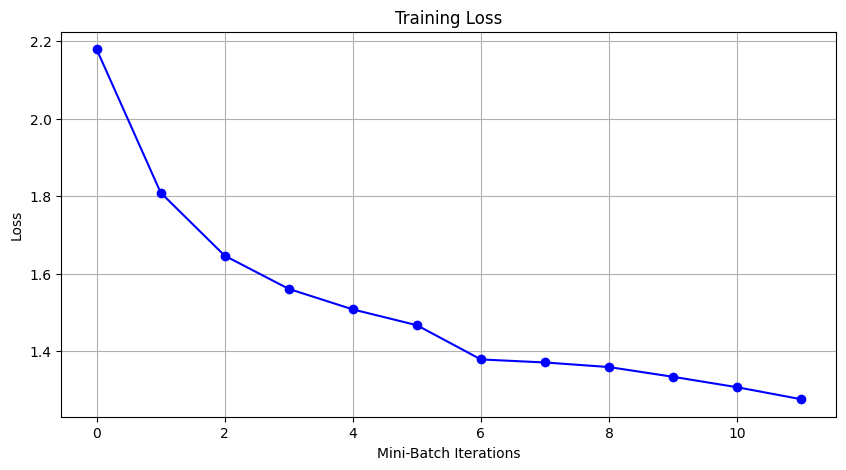

Finished Training


In [7]:
# 필요한 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt

# 에포크 동안의 손실값들을 저장하기 위한 리스트를 초기화합니다.
losses = []

# 총 2번의 에포크 동안 학습을 진행합니다.
for epoch in range(2):
    # 각 에포크별로 누적 손실값을 저장하기 위한 변수를 초기화합니다.
    running_loss = 0.0

    # 학습 데이터로더(trainloader)로부터 데이터를 미니배치 단위로 가져와 학습을 진행합니다.
    for i, data in enumerate(trainloader, 0):

        # data에서 입력 이미지와 해당 레이블을 가져옵니다.
        inputs, labels = data

        # 현재 저장된 그래디언트 정보를 초기화합니다.
        optimizer.zero_grad()

        # 입력 데이터를 신경망에 전달하여 출력 결과를 가져옵니다.
        outputs = net(inputs)

        # 신경망의 출력과 실제 레이블을 기반으로 손실값을 계산합니다.
        loss = criterion(outputs, labels)

        # 손실에 대한 그래디언트를 계산합니다.
        loss.backward()

        # 그래디언트를 기반으로 신경망의 가중치를 업데이트합니다.
        optimizer.step()

        # 누적 손실값을 업데이트합니다.
        running_loss += loss.item()

        # 2000 미니배치마다 손실값을 출력하고, 리스트에 저장합니다.
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losses.append(running_loss / 2000)
            running_loss = 0.0

# 학습 과정에서의 손실값을 시각화합니다.
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='b')
plt.xlabel('Mini-Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 학습 종료 메시지를 출력합니다.
print('Finished Training')


학습한 모델을 저장해보겠습니다:



In [8]:
# 학습된 신경망의 매개변수를 저장할 파일의 경로를 정의합니다.
PATH = './cifar_net.pth'

# 'net.state_dict()'는 신경망의 현재 매개변수(가중치와 편향)를 담고 있는 딕셔너리를 반환합니다.
# 'torch.save'를 사용하여 해당 딕셔너리를 파일(PATH)에 저장합니다. 이를 통해 나중에 신경망의 상태를 복원할 수 있습니다.
torch.save(net.state_dict(), PATH)


PyTorch 모델을 저장하는 자세한 방법은 [여기](https://pytorch.org/docs/stable/notes/serialization.html)
를 참조해주세요.

### 5. 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



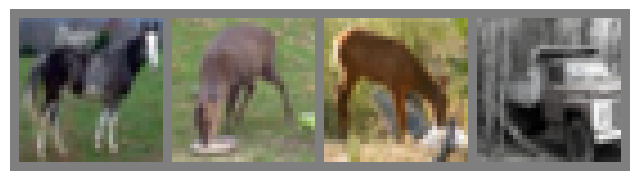

Labels:  horse deer  deer  truck


In [9]:
# 필요한 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 시각화하기 위한 함수를 정의합니다.
def imshow(img):
    # 이미지를 unnormalize합니다. 이전에 이미지를 [-1, 1] 범위로 정규화했으므로, 원래 범위인 [0, 1]로 되돌립니다.
    img = img / 2 + 0.5
    npimg = img.numpy()   # PyTorch 텐서를 Numpy 배열로 변환합니다.

    # Matplotlib을 사용하여 이미지를 시각화합니다.
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 이미지의 차원을 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경합니다.
    plt.axis('off')  # 이미지의 축을 숨깁니다.
    plt.show()

# 학습 데이터셋에서 무작위로 미니배치를 선택합니다.
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 선택한 이미지들을 격자 형태로 만든 후 시각화합니다.
imshow(torchvision.utils.make_grid(images))

# 선택한 이미지들의 레이블을 출력합니다.
print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [10]:
# Net 클래스로부터 신경망 모델의 인스턴스를 생성합니다.
net = Net()

# torch.load 함수를 사용하여 저장된 매개변수(가중치와 편향)를 로드합니다.
# 'PATH'는 저장된 모델의 파일 경로입니다.
# 이렇게 로드된 매개변수는 'net.load_state_dict'를 통해 신경망 모델에 적용(로드)됩니다.
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [11]:
# 'net'는 이전에 정의하고 로드한 신경망 모델입니다.
# 'images'는 입력으로 사용할 이미지 데이터 미니배치입니다.

# 이 코드는 신경망 모델 'net'에 이미지 미니배치 'images'를 전달하여 순전파를 수행합니다.
# 모델의 출력값은 'outputs'에 저장됩니다.
# 'outputs'는 각 이미지에 대한 클래스 점수(신경망의 로짓)를 포함하며,
# 이 점수는 후속 작업에서 확률 또는 예측 레이블로 변환될 수 있습니다.
outputs = net(images)


출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [12]:
# 'torch.max' 함수는 주어진 차원(여기서는 1번 차원)에 대한 최대값과 그 위치(인덱스)를 반환합니다.
# 'outputs'는 각 이미지에 대한 클래스 점수(로짓)를 포함하므로,
# 1번 차원에 대한 최대값을 찾으면 각 이미지에 대한 예측된 클래스의 인덱스를 얻을 수 있습니다.

# '_'는 최대값(로짓)을 받기 위한 변수이지만, 여기서는 해당 값에 관심이 없으므로 무시합니다.
# 'predicted'는 각 이미지에 대한 예측된 클래스의 인덱스를 포함하고 있습니다.
_, predicted = torch.max(outputs, 1)

# 'predicted'에 포함된 인덱스를 사용하여 'classes' 리스트에서 실제 클래스 이름을 찾아 출력합니다.
# 'range(4)'는 미니배치의 크기가 4라고 가정한 것입니다.
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


Predicted:  horse deer  horse truck


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [13]:
# 'correct'는 예측이 맞은 수를, 'total'은 전체 이미지 수를 저장하는 변수입니다.
correct = 0
total = 0

# 'torch.no_grad()'는 자동 미분 기능을 비활성화하여, 이후의 연산에서
# 변화도(gradient)를 계산하지 않도록 합니다.
# 이를 통해 메모리 사용량을 줄이고 연산 속도를 향상시킬 수 있습니다.
with torch.no_grad():
    # 'testloader'는 테스트 데이터의 이미지와 레이블을 제공하는 데이터 로더입니다.
    for data in testloader:
        # 'data'는 [images, labels]의 형태로, 테스트 데이터의 이미지와 레이블을 포함합니다.
        images, labels = data
        # 신경망에 이미지를 통과시켜 각 클래스에 대한 로짓(출력)을 계산합니다.
        outputs = net(images)
        # 'outputs.data'에서 최대값을 가지는 인덱스를 찾습니다.
        # 이 인덱스는 예측된 클래스를 나타냅니다.
        _, predicted = torch.max(outputs.data, 1)
        # 'labels.size(0)'는 미니배치의 크기(이미지 수)를 나타냅니다.
        total += labels.size(0)
        # 'predicted == labels'는 예측과 실제 레이블이 일치하는지를 검사합니다.
        # 'sum().item()'을 통해 일치하는 예측의 수를 구합니다.
        correct += (predicted == labels).sum().item()

# 전체 테스트 이미지에 대한 모델의 정확도를 계산하여 출력합니다.
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 55 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



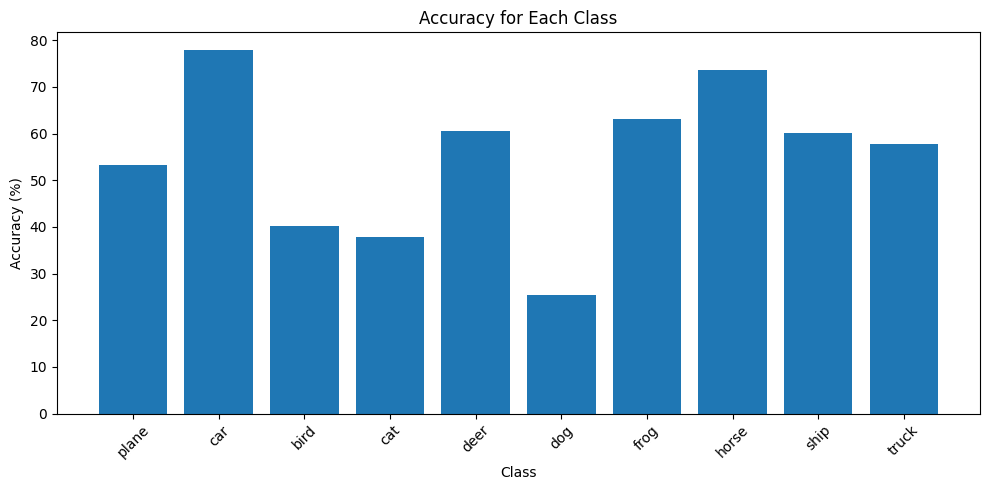

In [14]:
import matplotlib.pyplot as plt

# 각 클래스의 이름을 기반으로 정확한 예측 수와 전체 예측 수를 저장하기 위한 딕셔너리를 초기화합니다.
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 학습 또는 역전파가 필요 없기 때문에 'torch.no_grad()' 컨텍스트를 사용하여
# 메모리 사용량을 줄이고 속도를 높입니다.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)  # 각 이미지에 대한 최고 점수를 가진 클래스의 인덱스를 가져옵니다.

        # 각 예측에 대해 실제 레이블과 예측된 레이블을 비교합니다.
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1  # 올바르게 예측된 경우
            total_pred[classes[label]] += 1       # 전체 예측 횟수

# 각 클래스에 대한 정확도를 계산하고 리스트에 저장합니다.
class_accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    class_accuracies.append(accuracy)

# matplotlib를 사용하여 각 클래스의 정확도를 바 차트로 시각화합니다.
plt.figure(figsize=(10, 5))
plt.bar(classes, class_accuracies)
plt.xlabel('Class')               # x축 레이블
plt.ylabel('Accuracy (%)')       # y축 레이블
plt.title('Accuracy for Each Class')  # 차트 제목
plt.xticks(rotation=45)          # x축의 텍스트 레이블을 45도 회전하여 겹치지 않게 합니다.
plt.tight_layout()               # 그래프의 레이아웃을 조정하여 가장 잘 맞게 만듭니다.
plt.show()                       # 그래프를 화면에 표시합니다.


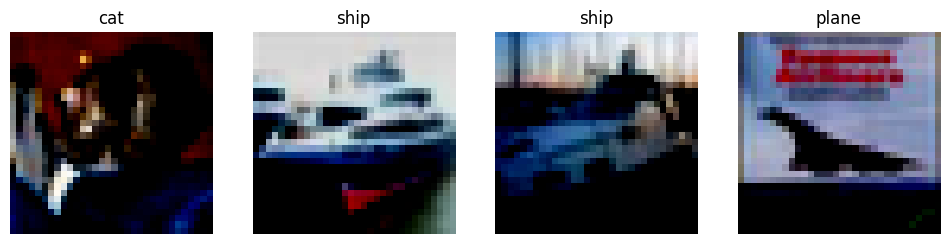

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 'iter()'와 'next()'를 사용하여 'testloader'에서 첫 번째 배치의 데이터를 가져옵니다.
dataiter = iter(testloader)
images, labels = next(dataiter)

# matplotlib를 사용하여 1행 4열의 서브플롯 그리드를 생성합니다.
# 이 그리드는 4개의 이미지를 나란히 표시하기 위한 것입니다.
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# 첫 4개의 이미지와 레이블을 반복하며 표시합니다.
for i in range(4):
    image = images[i]           # i번째 이미지를 가져옵니다.
    label = classes[labels[i]]  # i번째 레이블에 해당하는 클래스 이름을 가져옵니다.

    # PyTorch는 이미지를 (채널, 높이, 너비) 형태로 저장합니다.
    # 'np.transpose()'를 사용하여 이를 (높이, 너비, 채널) 형태로 변환합니다.
    # 이렇게 해야 matplotlib로 이미지를 올바르게 표시할 수 있습니다.
    image = np.transpose(image.numpy(), (1, 2, 0))

    axs[i].imshow(image)          # 이미지를 서브플롯에 표시합니다.
    axs[i].set_title(label)      # 해당 이미지의 레이블을 서브플롯의 제목으로 설정합니다.
    axs[i].axis('off')           # 서브플롯의 축을 숨깁니다.

# 생성된 그림을 표시합니다.
plt.show()


자, 이제 다음으로 무엇을 해볼까요?

이러한 신경망들을 GPU에서 실행하려면 어떻게 해야 할까요?

## GPU에서 학습하기
Tensor를 GPU로 이동했던 것처럼, 신경망 또한 GPU로 옮길 수 있습니다.

먼저 (CUDA를 사용할 수 있다면) 첫번째 CUDA 장치를 사용하도록 설정합니다:



In [16]:
# torch 라이브러리의 device 기능을 사용하여 실행 중인 환경에서 CUDA-enabled GPU가 사용 가능한지 확인합니다.
# 사용 가능하면 'cuda:0' (첫 번째 GPU)를 반환하고, 그렇지 않으면 'cpu'를 반환합니다.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 선택된 기기를 출력합니다. 예를 들어, CUDA-enabled GPU가 있다면 'cuda:0'이 출력됩니다.
# CUDA가 사용 가능하지 않으면 'cpu'가 출력됩니다.
print(device)


cuda:0


이 섹션의 나머지 부분에서는 ``device`` 를 CUDA 장치라고 가정하겠습니다.

그리고 이 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를
CUDA tensor로 변경합니다:

.. code:: python

    net.to(device)


또한, 각 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억해야
합니다:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

CPU와 비교했을 때 어마어마한 속도 차이가 나지 않는 것은 왜 그럴까요?
그 이유는 바로 신경망이 너무 작기 때문입니다.

**연습:** 신경망의 크기를 키워보고, 얼마나 빨라지는지 확인해보세요.
(첫번째 ``nn.Conv2d`` 의 2번째 인자와 두번째 ``nn.Conv2d`` 의 1번째 인자는
같은 숫자여야 합니다.)

**다음 목표들을 달성했습니다**:

- 높은 수준에서 PyTorch의 Tensor library와 신경망을 이해합니다.
- 이미지를 분류하는 작은 신경망을 학습시킵니다.

## 여러개의 GPU에서 학습하기
모든 GPU를 활용해서 더욱 더 속도를 올리고 싶다면, :doc:`data_parallel_tutorial`
을 참고하세요.

## 이제 무엇을 해볼까요?

-  :doc:`비디오 게임을 할 수 있는 신경망 학습시키기 </intermediate/reinforcement_q_learning>`
-  `imagenet으로 최첨단(state-of-the-art) ResNet 신경망 학습시키기`_
-  `적대적 생성 신경망으로 얼굴 생성기 학습시키기`_
-  `순환 LSTM 네트워크를 사용해 단어 단위 언어 모델 학습시키기`_
-  `다른 예제들 참고하기`_
-  `더 많은 튜토리얼 보기`_
-  `포럼에서 PyTorch에 대해 얘기하기`_
-  `Slack에서 다른 사용자와 대화하기`_




In [17]:
# 'dataiter' 객체를 메모리에서 명시적으로 삭제합니다.
# 이렇게 하면, 더 이상 필요하지 않은 객체를 제거하여 메모리를 효율적으로 관리할 수 있습니다.
del dataiter
